In [6]:
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3" # "0,1,2,3" # "0"

In [7]:
import numpy as np
import h5py
import cv2
import os, sys
import argparse
from core.get_args import get_args
from core.produce_denoised_img import produce_denoised_img_no_crop
from core.utils import TedataLoader
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from core.watershed import watershed,watershed_per_img,watershed_original,watershed_test
from core.median_filter import apply_median_filter_cpu, apply_median_filter_gpu, apply_median_filter_gpu_simple
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def filtering(img,filter_width=50):
    gray = img
    height, width = img.shape
    dft = cv2.dft(np.float32(gray), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    row, col = int(height / 2), int(width / 2)
    LPF = np.zeros((height, width, 2), np.uint8)
    LPF[row - filter_width:row + filter_width, col - filter_width:col + filter_width] = 1
    LPF_shift = dft_shift * LPF
    LPF_ishift = np.fft.ifftshift(LPF_shift)
    LPF_img = cv2.idft(LPF_ishift)
    LPF_img = cv2.magnitude(LPF_img[:, :, 0], LPF_img[:, :, 1])
    out = 20*np.log(cv2.magnitude(LPF_shift[:, :, 0], LPF_shift[:, :, 1]))

    HPF = np.ones((height, width, 2), np.uint8)
    HPF[row - filter_width:row + filter_width, col - filter_width:col + filter_width] = 0
    HPF_shift = dft_shift * HPF
    HPF_ishift = np.fft.ifftshift(HPF_shift)
    HPF_img = cv2.idft(HPF_ishift)
    HPF_img = cv2.magnitude(HPF_img[:, :, 0], HPF_img[:, :, 1])
    out2 = 20*np.log(cv2.magnitude(HPF_shift[:, :, 0], HPF_shift[:, :, 1]))

    plt.subplot(151), plt.imshow(gray, cmap='gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(152), plt.imshow(LPF_img, cmap='gray')
    plt.title('LPF'), plt.xticks([]), plt.yticks([])
    plt.subplot(153), plt.imshow(out, cmap='gray')
    plt.title('out1'), plt.xticks([]), plt.yticks([])
    plt.subplot(154), plt.imshow(HPF_img, cmap='gray')
    plt.title('HPF'), plt.xticks([]), plt.yticks([])
    plt.subplot(155), plt.imshow(out2, cmap='gray')
    plt.title('out2'), plt.xticks([]), plt.yticks([])

    plt.show()
def LPF_filtering(img,filter_width=50):
    gray = img
    height, width = img.shape
    dft = cv2.dft(np.float32(gray), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    row, col = int(height / 2), int(width / 2)
    LPF = np.zeros((height, width, 2), np.uint8)
    LPF[row - filter_width:row + filter_width, col - filter_width:col + filter_width] = 1
    LPF_shift = dft_shift * LPF
    LPF_ishift = np.fft.ifftshift(LPF_shift)
    LPF_img = cv2.idft(LPF_ishift)
    LPF_img = cv2.magnitude(LPF_img[:, :, 0], LPF_img[:, :, 1])
def HPF_filtering(img,filter_width=50):
    gray = img
    height, width = img.shape
    dft = cv2.dft(np.float32(gray), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    row, col = int(height / 2), int(width / 2)

    HPF = np.ones((height, width, 2), np.uint8)
    HPF[row - filter_width:row + filter_width, col - filter_width:col + filter_width] = 0
    HPF_shift = dft_shift * HPF
    HPF_ishift = np.fft.ifftshift(HPF_shift)
    HPF_img = cv2.idft(HPF_ishift)
    HPF_img = cv2.magnitude(HPF_img[:, :, 0], HPF_img[:, :, 1])
    return HPF_img


In [9]:
data_path = f"./intermediate_result/full_img_dict.npy"
print(data_path.split("/")[2:])
img_dict = np.load(data_path,allow_pickle=True).item()

index = 0

F8_1 = img_dict['SET01']['F08'][index][0]
F8_1_uint8 = (F8_1*255).astype('uint8')

['full_img_dict.npy']


['denoised_img_F08_v2_img_dict.npy']
(1474, 3010)


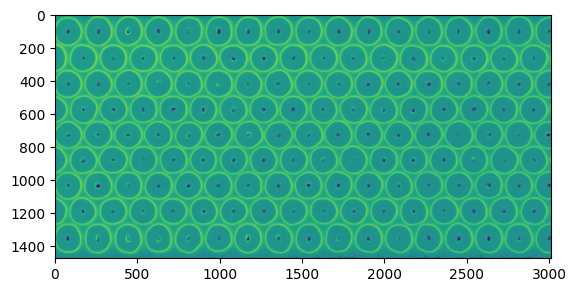

In [23]:
target = 'F08_v2'
data_path = f"./intermediate_result/denoised_img_{target}_img_dict.npy"
print(data_path.split("/")[2:])
img_dict = np.load(data_path,allow_pickle=True).item()

index = 0
F8_1 = img_dict['SET01']['F08'][index][0]
F8_1_uint8 = (F8_1*255).astype('uint8')
print(F8_1_uint8.shape)
plt.imshow(F8_1_uint8)

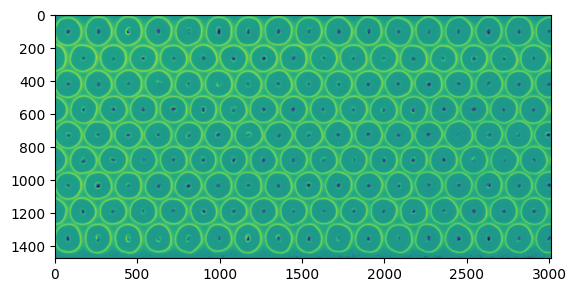

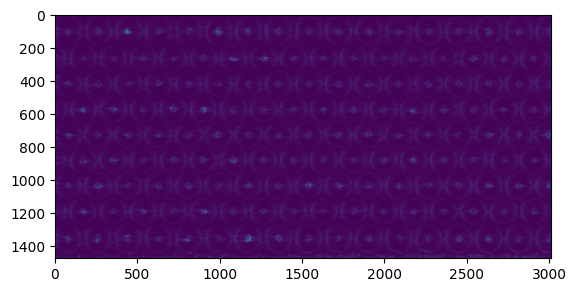

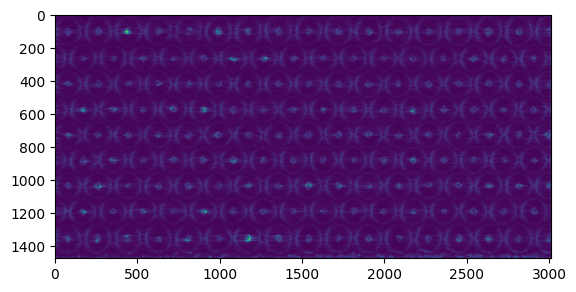

In [124]:
plt.imshow(F8_1)
plt.pause(0.01)
HBF_img = HPF_filtering(F8_1.copy(),200)
plt.imshow(HBF_img)
plt.pause(0.01)
BPF_img = LPF_filtering(HBF_img,230)
plt.imshow(BPF_img)
print("")

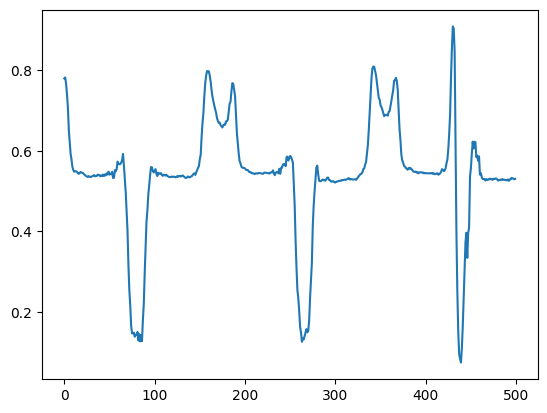

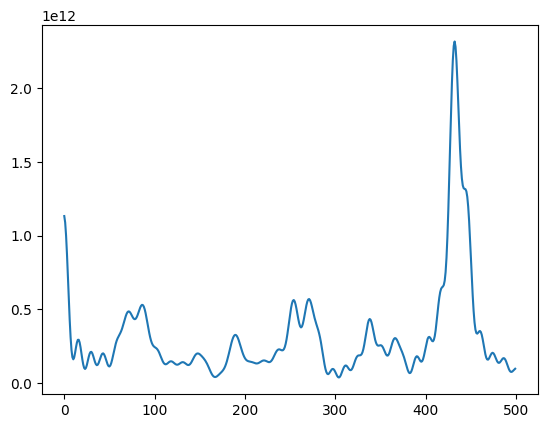

In [125]:
plt.plot(F8_1[100,:500])
plt.pause(0.01)
plt.plot(BPF_img[100,:500])

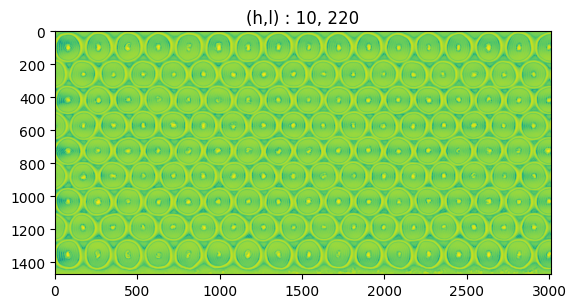

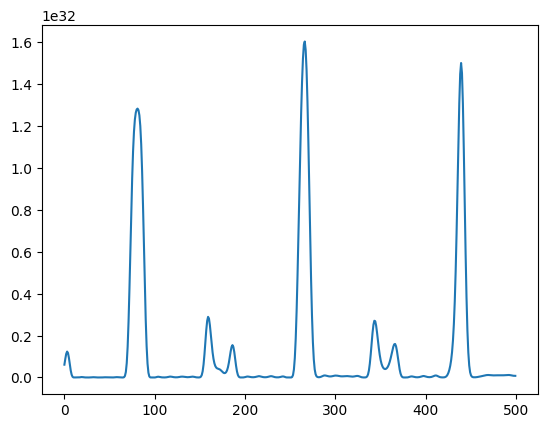

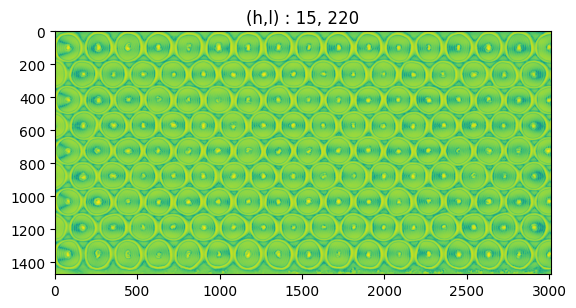

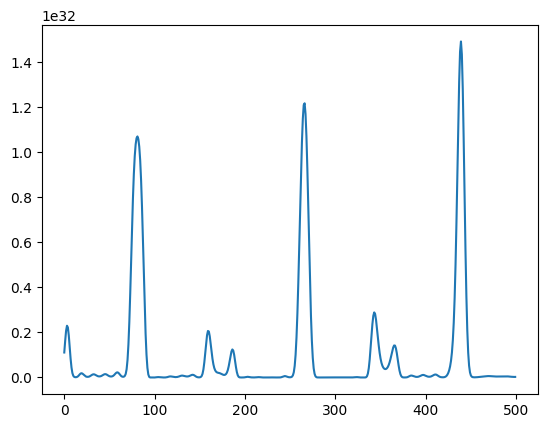

In [134]:
# for h_param in range(0,150,10):
for h_param in range(10,20,5):
    HBF_img = HPF_filtering(F8_1.copy(),h_param)
    for l_param in range(220,230,10):
        BPF_img = LPF_filtering(HBF_img,l_param)
        BPF_img = np.log(BPF_img)
        # print(f"(h,l) : {h_param}, {l_param}")
        plt.title(f"(h,l) : {h_param}, {l_param}")
        # print(BPF_img.dtype)
        plt.imshow(BPF_img)
        plt.pause(0.01)
        plt.plot(12**(BPF_img[100,:500]))
        plt.pause(0.01)

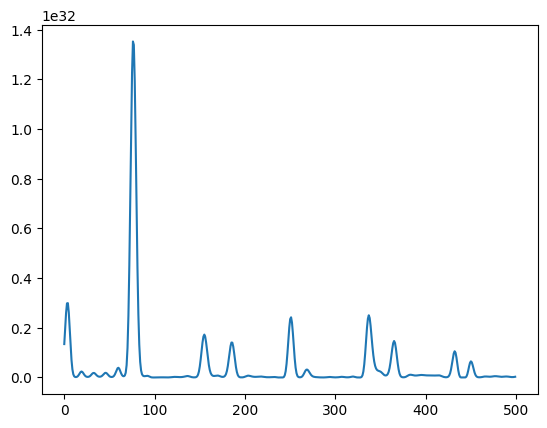

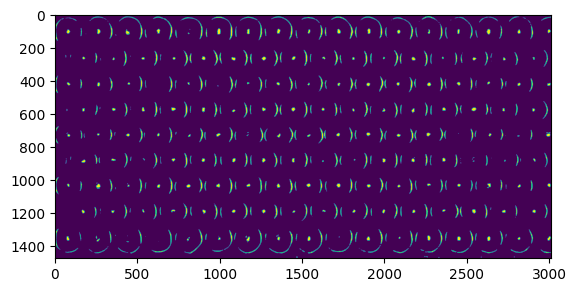

In [148]:
test = (BPF_img).copy()
# plt.plot(12**test[100,:500])

plt.plot(12**test[1350,:500])
plt.pause(0.01)
test[np.where(12**test < 1.5 * 10**31)] = 0
plt.imshow(test)

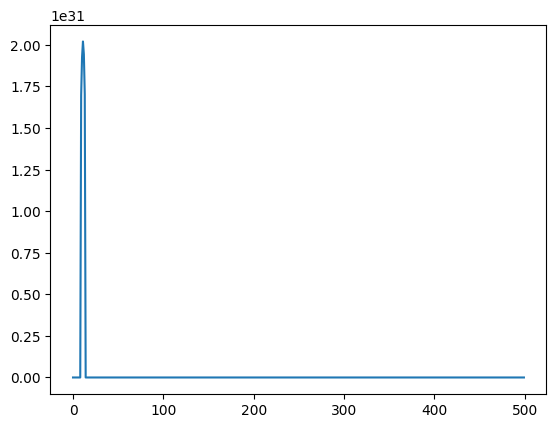

In [147]:

plt.plot(12**test[1400,:500])

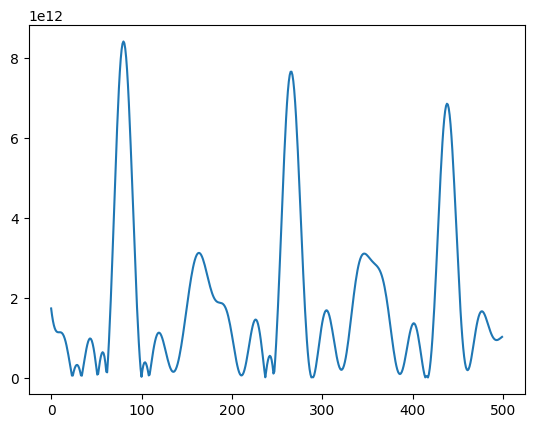

In [30]:
plt.plot(BPF_img[100][:500])

In [ ]:
a = 
np.argmax(np.bincount(a.flatten()))

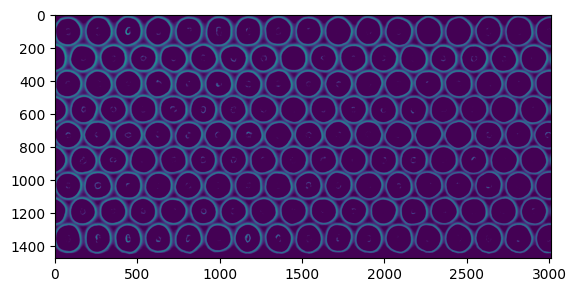

In [79]:
# test = BPF_img.copy()
F8_1_uint8 = (F8_1*255).astype('uint8')
test = F8_1_uint8.copy()
 
threshold = np.argmax(np.bincount(test.flatten())) + 15
# test[np.where(test < 5*10**12)] = 0
test[np.where(test < threshold)] = threshold
plt.imshow(test)

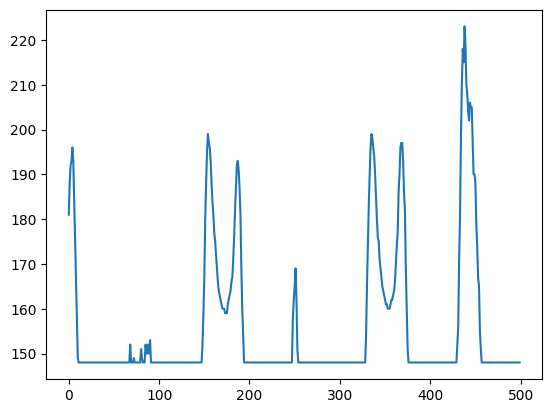

In [82]:
plt.plot(test[-100][:500])

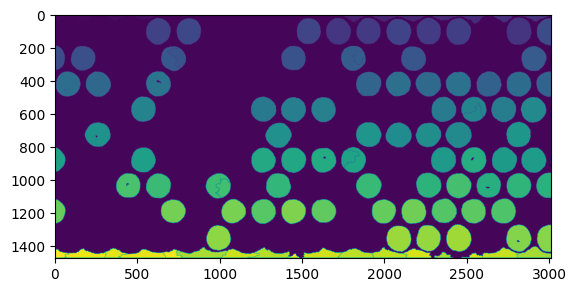

In [74]:
F8_1_uint8 = (F8_1*255).astype('uint8')
r = watershed_original(F8_1_uint8)
plt.imshow(r)

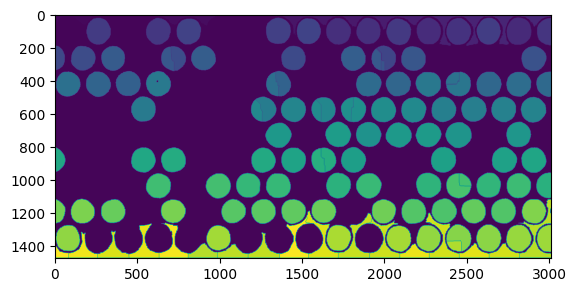

In [80]:
# test_uint8 = (test*255).astype('uint8')
r = watershed_original(test)
plt.imshow(r)